 # golub dataset

In [1]:
# install.packages("binom") # Installed from R studio as needs compilation
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("cancerclass")

In [2]:
library("binom") 
library("evaluomeR")
library("cancerclass")
library("dplyr")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

# Table of contents
* [Dataset](#dataset)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
load("leukemia.RData")
golub = as.data.frame(leukemia)

In [4]:
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


In [5]:
unique(golub["Class"])

,Class
1,B
2,T
28,M


In [6]:
# https://rdrr.io/bioc/cancerclass/man/GOLUB.html

In [7]:
# data(GOLUB1)
# golub = as.data.frame(rdata_golub)

In [8]:
head(golub)
print(paste0("Rows: ", nrow(golub)))
print(paste0("Columns: ", ncol(golub)))
# En el artículo dice: The data are then summarized by a 72 × 3,571

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


[1] "Rows: 72"
[1] "Columns: 102"


In [9]:
#golub["class"] = NULL
golub["Class"] = NULL # leukemia
golub["sample"] = NULL
golub["type"] = NULL
golub["FAB"] = NULL
golub["gender"] = NULL
print(paste0("Rows: ", nrow(golub)))
print(paste0("Columns: ", ncol(golub)))
#golub["labels"] = rownames(golub)
#golub = golub[ , c("labels", names(golub)[names(golub) != "labels"])] 

[1] "Rows: 72"
[1] "Columns: 101"


In [10]:
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


In [11]:
variance = sort(sapply(golub[-1], var,na.rm = TRUE), decreasing = TRUE)  # Sorted gene variance
gene_var = as.data.frame(variance)
gene_var["gene"] = rownames(gene_var)
head(gene_var)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [12]:
top_number = 100
top_genes = gene_var[c(1:top_number), ]
head(top_genes)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [13]:
gene_list = as.list(top_genes["gene"])

In [14]:
top_gene_list = unlist(setdiff(gene_list, names(golub)))
top_gene_list

[1] "X82240_rna1_at"          "M27891_at"              
  [3] "M26311_s_at"             "AFFX.HUMRGE.M10098_5_at"
  [5] "Y00787_s_at"             "M84526_at"              
  [7] "M19507_at"               "D88270_at"              
  [9] "M63438_s_at"             "M28130_rna1_s_at"       
 [11] "AFFX.HUMRGE.M10098_M_at" "M12886_at"              
 [13] "M91036_rna1_at"          "AFFX.HUMRGE.M10098_3_at"
 [15] "AFFX.M27830_5_at"        "X00437_s_at"            
 [17] "M21005_at"               "M87789_s_at"            
 [19] "M58459_at"               "M11722_at"              
 [21] "U01317_cds4_at"          "M21305_at"              
 [23] "M27783_s_at"             "L33930_s_at"            
 [25] "J04164_at"               "J04456_at"              
 [27] "X58529_at"               "U89922_s_at"            
 [29] "M21119_s_at"             "M25079_s_at"            
 [31] "M89957_at"               "Z83821_cds2_at"         
 [33] "M57710_at"               "M38690_at"              
 [35] "M57466_s_at"             "X05908_at"              
 [37] "X77737_at"               "M34516_at"              
 [39] "M91438_at"               "M96326_rna1_at"         
 [41] "U05259_rna1_at"          "X76223_s_at"            
 [43] "K01911_at"               "D88422_at"              
 [45] "U05255_s_at"             "X04500_at"              
 [47] "HG3576.HT3779_f_at"      "X95735_at"              
 [49] "X64072_s_at"             "D83735_at"              
 [51] "D83920_at"               "M21904_at"              
 [53] "J03909_at"               "AF000424_s_at"          
 [55] "Z23090_at"               "D13639_at"              
 [57] "J04102_at"               "U57341_at"              
 [59] "M15395_at"               "Z84721_cds2_at"         
 [61] "M38591_at"               "D87433_at"              
 [63] "U46499_at"               "X17042_at"              
 [65] "M63573_at"               "U09770_at"              
 [67] "U20734_s_at"             "M94345_at"              
 [69] "M23178_s_at"             "M11717_rna1_at"         
 [71] "M57731_s_at"             "J03077_s_at"            
 [73] "HG987.HT987_at"          "U02687_at"              
 [75] "L08895_at"               "M12759_at"              
 [77] "M34996_s_at"             "M13560_s_at"            
 [79] "M74719_at"               "X59871_at"              
 [81] "M92934_at"               "U23852_s_at"            
 [83] "U50743_at"               "U60644_at"              
 [85] "U10485_at"               "Z22548_at"              
 [87] "L20971_at"               "M33882_at"              
 [89] "J04615_at"               "X62744_at"              
 [91] "Z69881_at"               "M16279_at"              
 [93] "M21624_at"               "U02020_at"              
 [95] "M16336_s_at"             "L19686_rna1_at"         
 [97] "X65965_s_at"             "X03934_at"              
 [99] "M28826_at"               "M30703_s_at"

In [15]:
top_golub = golub[, top_gene_list]
top_golub["labels"] = rownames(top_golub)
top_golub = top_golub[ , c("labels", names(top_golub)[names(top_golub) != "labels"])] 

In [16]:
head(top_golub)

labels,X82240_rna1_at,M27891_at,M26311_s_at,AFFX.HUMRGE.M10098_5_at,Y00787_s_at,M84526_at,M19507_at,D88270_at,M63438_s_at,...,Z69881_at,M16279_at,M21624_at,U02020_at,M16336_s_at,L19686_rna1_at,X65965_s_at,X03934_at,M28826_at,M30703_s_at
1,4.16170,2.48144,2.00000,4.16250,2.52244,2.0000,2.0000,3.29336,3.75143,...,3.24699,3.48841,2.43457,2.24551,2.00000,2.89487,2.83059,2.79449,2.00000,2
2,2.00000,3.13290,3.64856,2.78888,3.72795,2.0000,2.0000,2.29667,3.68646,...,3.30428,4.01932,4.07185,3.05690,3.31513,3.86094,3.40926,3.88434,2.00000,2
3,2.00000,2.40483,2.88930,3.75351,2.47857,2.0000,2.0000,2.76268,2.00000,...,3.55096,3.97211,2.26007,2.06070,3.56384,3.79616,2.52763,4.05312,3.94379,2
4,3.71659,2.00000,2.19590,3.68574,2.38202,2.0000,2.0000,3.68851,2.00000,...,2.91803,3.17406,2.00000,2.00000,2.00000,2.79449,2.43457,2.67578,2.00000,2
5,3.77772,2.00000,3.33746,3.10857,2.00000,2.4624,2.9722,3.52930,2.83696,...,3.17493,3.67596,2.00000,2.33646,2.00000,3.78810,2.56820,2.53782,2.00000,2
6,2.00000,3.06744,3.20737,3.61784,2.33244,2.0000,2.0000,2.00000,2.00000,...,3.41597,3.94655,2.00000,2.00000,3.50947,3.55425,2.50651,3.85485,3.69522,2


# evaluomeR K analysis

In [17]:
seed = 13606
k.range=c(3,10)
cbi = "clara"
top_golub = golub
colnames(top_golub)[colnames(top_golub) == 'Case'] <- 'Description'
# Stab
golub_stab_range = stabilityRange(data=top_golub, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
golub_stab = standardizeStabilityData(golub_stab_range)

# Qual
golub_qual_range = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
golub_qual = standardizeQualityData(golub_qual_range)

# K opt
golub_k_opt = getOptimalKValue(golub_stab_range, golub_qual_range, k.range= k.range)
print(paste0("Optimal k = ", golub_k_opt$Global_optimal_k))
print(paste0("Stabilities with: ", cbi))
golub_stab
print(paste0("Qualities with: ", cbi))
golub_qual
head(top_golub)


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
Processing metric: all_metrics

	Maximum stability and quality values matches the same K value: '3'



[1] "Optimal k = 3"
[1] "Stabilities with: clara"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.7853092,0.7537019,0.6352238,0.5512476,0.5027411,0.5753578,0.6026215,0.6276503


[1] "Qualities with: clara"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.2320141,0.1299018,0.09750963,0.08118129,0.07984548,0.1031934,0.09457494,0.09856581


Description,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


# Clusters

In [18]:
individuals_per_cluster = function(qualityResult) {
  qual_df = as.data.frame(assay(qualityResult))


  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [19]:
qual_df = as.data.frame(assay(golub_qual_range$k_3))
qual_df

Metric,Cluster_1_SilScore,Cluster_2_SilScore,Cluster_3_SilScore,Avg_Silhouette_Width,Cluster_1_Size,Cluster_2_Size,Cluster_3_Size,Cluster_position,Cluster_labels
all_metrics,0.239437234107337,0.350656631802549,0.186688384143229,0.23201412622582,37,8,27,"1,2,2,1,1,2,1,1,2,2,2,1,1,2,1,1,3,1,1,1,1,1,2,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3","B1,T1,T2,B2,B3,T3,B4,B5,T4,T5,T6,B6,B7,T7,B8,B9,B10,B11,B12,B13,B14,B15,T8,B16,B17,B18,B19,AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML10,AML11,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B32,B33,B34,B35,T9,B36,B37,B38,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML22,AML23,AML24,AML25"


In [20]:
golub_k3_clara = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi="clara")
golub_clara = individuals_per_cluster(assay(golub_k3_clara$k_3))
print("Clara k3")
for (cluster_i in 1:max(unlist(unique(golub_clara["InCluster"])))) {
    ind_in_cluster = paste(unlist(golub_clara[golub_clara$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("---")
}


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


[1] "Clara k3"
[1] "Cluster 1 : B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B32,B33,B34,B35,B36,B37,B38"
[1] "---"
[1] "Cluster 2 : T1,T2,T3,T4,T5,T6,T7,T8"
[1] "---"
[1] "Cluster 3 : B10,AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML10,AML11,T9,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML22,AML23,AML24,AML25"
[1] "---"


In [21]:
golub_k4_kmeans = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi="kmeans")
golub_kmeans = individuals_per_cluster(assay(golub_qual_range$k_4))
print("k4")
for (cluster_i in 1:max(unlist(unique(golub_kmeans["InCluster"])))) {
    ind_in_cluster = paste(unlist(golub_kmeans[golub_kmeans$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("---")
}


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


[1] "k4"
[1] "Cluster 1 : B1,B5,B6,B7,B8,B11,B12,B13,B15,B17,B18,B20,B22,B23,B24,B25,B27,B28,B29,B30,B31,B32,B33,B35,B37,B38"
[1] "---"
[1] "Cluster 2 : T1,T2,T3,T4,T5,T6,T7,T8"
[1] "---"
[1] "Cluster 3 : B2,B3,B4,B9,B14,B16,B19,B21,B26,B34,B36,AML22"
[1] "---"
[1] "Cluster 4 : B10,AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML10,AML11,T9,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML23,AML24,AML25"
[1] "---"


In [22]:
golub_stab
golub_qual

,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.7853092,0.7537019,0.6352238,0.5512476,0.5027411,0.5753578,0.6026215,0.6276503


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.2320141,0.1299018,0.09750963,0.08118129,0.07984548,0.1031934,0.09457494,0.09856581


In [23]:
top_golub_copy = top_golub
top_golub[-1]

AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,D88422_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.00000,3.29336,2.20683,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.00000,2.29667,2.76938,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.00000,2.76268,2.31597,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.00000,3.68851,2.00000,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.40140,3.52930,2.52763,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.00000,2.00000,2.30103,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000
4.20412,4.04261,4.20412,3.88992,2.18752,2.00000,2.00000,2.00000,3.17811,2.00000,...,2.00000,2.34830,2.00000,2.00000,2.21484,2.84510,3.17377,3.04415,2.26951,2.00000
3.59483,3.18977,3.11361,3.63114,3.36661,2.00000,2.00000,2.48855,3.09621,2.08279,...,2.56229,3.21590,2.16137,2.00000,2.84696,3.57310,3.41111,3.70001,2.00000,2.82282
4.11411,3.86165,4.14423,3.78633,3.26670,3.08955,2.65418,2.00000,2.00000,2.10380,...,4.15503,2.69373,4.11919,3.01953,2.00000,2.03342,2.00000,2.00000,3.38274,2.92012
2.00000,2.00000,2.00000,2.00000,2.05690,2.01284,2.81954,2.00000,2.56229,2.43457,...,4.20377,2.55509,3.74726,2.90849,2.93902,2.00000,2.11059,2.08279,2.94052,2.00000


In [24]:
# -- Clest
golub_clest = Clest(as.matrix(top_golub_copy[-1]), maxK = 6, alpha=0, B=3, B0=10, beta = 0.01, nstart=100,pca=FALSE,L1=3,silent=TRUE);

RSKC will be performed (maxK-1)*(B0*1*(1+1)+B*(1+1))= 130 times

Assessing the observed data 


In [25]:
names(golub_clest)
golub_clest$observedCERs
golub_clest$K

[1] "call"          "K"             "result.table"  "referenceCERs"
[5] "observedCERs"

k=2,3,4,5,6
0.3442029,0.1304348,0.14492754,0.15579710,0.1702899
0.1594203,0.2173913,0.07608696,0.09782609,0.1304348
0.0000000,0.0000000,0.18115942,0.22101449,0.1920290


[1] 2

In [26]:
?Clest

# PCA <a class="anchor" id="pca"></a>

In [27]:
#PCA
#top_golub["inCluster"] = golub_k$InCluster
print(length(golub_clara$InCluster))
print(nrow(top_golub))
top_golub["inCluster"] = as.numeric(golub_clara$InCluster)
unique(golub_clara$InCluster)

[1] 72
[1] 72


[[1]]
[1] "1"

[[2]]
[1] "2"

[[3]]
[1] "3"

In [28]:
pca_matrix = top_golub %>% select(-Description, -inCluster)
head(pca_matrix)

AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,D88422_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,2.20683,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,2.76938,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,2.31597,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,2.00000,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,2.52763,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,2.30103,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


In [29]:
pca_result <- prcomp(pca_matrix, scale. = TRUE)

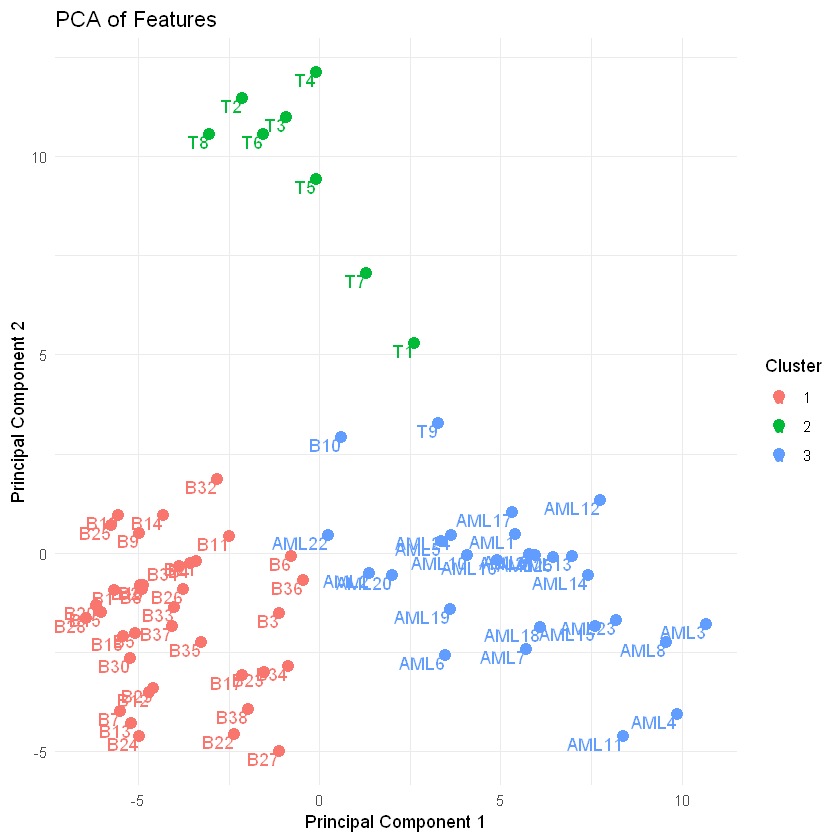

In [30]:
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_golub$inCluster)
pca_df$Individual <- top_golub$Description

# Plot PCA results

ggplot2::ggplot(pca_df, ggplot2::aes(x = PC1, y = PC2, color = Cluster, label = Individual)) +
  ggplot2::geom_point(size = 3) +
  ggplot2::geom_text(vjust = 1, hjust = 1) +
  ggplot2::labs(title = "PCA of Features",
       x = "Principal Component 1",
       y = "Principal Component 2") +
  ggplot2::theme_minimal()

# Sensitivity <a class="anchor" id="sensitivity"></a>

In [31]:
library("MLmetrics")


Attaching package: 'MLmetrics'

The following object is masked from 'package:RSKC':

    Sensitivity

The following object is masked from 'package:base':

    Recall



In [32]:
top_golub["Class"] = as.data.frame(leukemia)["Class"]
head(top_golub)[, c("Description", "Class")]

Description,Class
B1,B
T1,T
T2,T
B2,B
B3,B
T3,T


In [39]:
# Define levels and their corresponding numbers
# Order is important
level_mapping <- c("B" = 1, "T" = 2, "M" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}

In [34]:
top_golub["Class_n"] = lapply(top_golub["Class"], map_strings_to_numbers)
head(top_golub)[, c("Description", "Class", "Class_n")]

Description,Class,Class_n
B1,B,1
T1,T,2
T2,T,2
B2,B,1
B3,B,1
T3,T,2


In [38]:
# Getting a vector of clusters
actual = as.factor(as.vector(unlist(top_golub["Class_n"])))
predicted <- factor(as.vector(unlist(top_golub["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

[1] "predicted"


[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 3 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

In [36]:
sens <- Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 97.37%"


# CER <a class="anchor" id="cer"></a>

In [37]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 3.76%"
